[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ronghuaxueleng/colab-stable-diffusion-webui/blob/20230725/hugggingface_to_ali.ipynb)

### 一、准备工作

In [ ]:
!apt-get -y install -qq aria2
!pip install gradio aligo huggingface_hub
import os
import shutil
from huggingface_hub import snapshot_download
from aligo import set_config_folder, Aligo
from google.colab import drive
drive.mount('/content/drive')
set_config_folder('/content/drive/MyDrive/aligo')
ali = Aligo()
print(ali.get_user())

In [3]:
def copy_data(source_directory,target_directory):
  for entry in os.scandir(source_directory):
        if entry.is_dir():
            # 如果是目录，则递归复制子目录
            subdirectory = os.path.join(target_directory, entry.name)
            os.makedirs(subdirectory, exist_ok=True)
            copy_data(entry.path, subdirectory)
        else:
            # 如果是文件，则直接复制到目标目录
            shutil.copy2(entry.path, target_directory)


def download(repo_id):
    source_directory = snapshot_download(repo_id=repo_id, cache_dir="/app/data/", force_download=True)
    print("文件路径:", source_directory)
    path_name = repo_id.replace("/", "---")
    target_directory = f"{os.getcwd()}/download/{path_name}"

    os.makedirs(target_directory, exist_ok=True)  # 创建目标目录，如果目录已存在则不会报错

    copy_data(source_directory, target_directory)
    print("复制路径：", target_directory)

    return target_directory

### 二、输入您要下载模型的名称
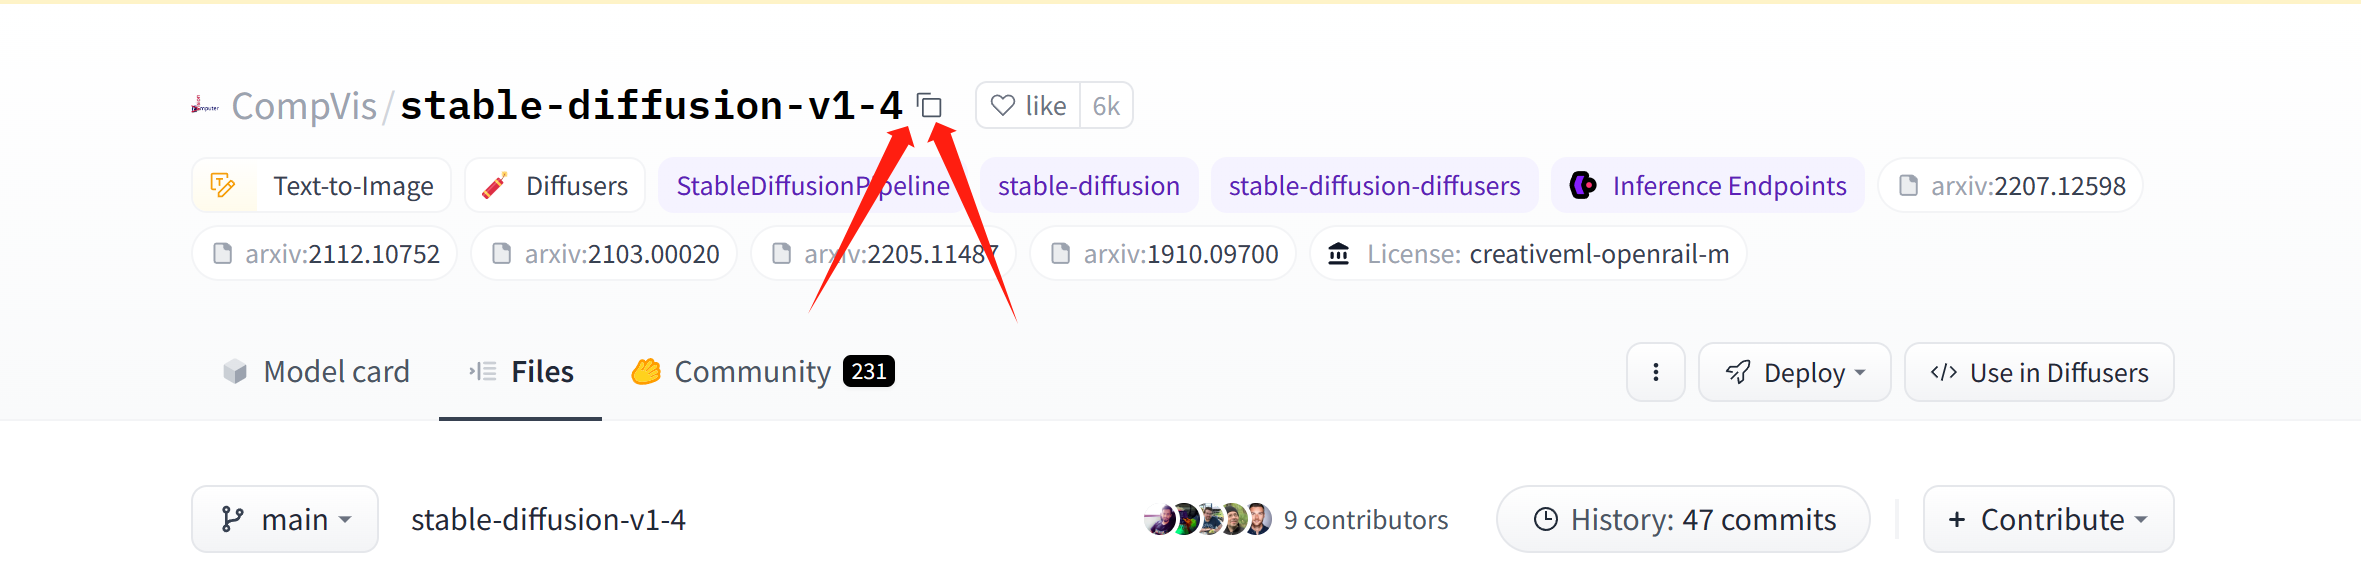

In [25]:
repo_id = "Iceclear/StableSR" # @param{'type': 'string'}
files = "webui_512v_models.zip" # @param{'type': 'string'}

### 三、一键拉取到colab

In [ ]:
path_name = repo_id.replace("/", "---")
target_directory = f"{os.getcwd()}/download/{path_name}"
os.makedirs(target_directory, exist_ok=True)
# out_path = download(repo_id)
for file in files.split(","):
  file_url = f"https://huggingface.co/{repo_id}/resolve/main/{file}"
  print(file_url)
  !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {file_url} -d {target_directory} -o {file}
!ls -lh {target_directory}

### 四、保存到阿里云盘

In [6]:
def upload_by_path(source_path,compress=True):
    # 创建目录
    dest_path = source_path.split("/")[-1]
    # # 压缩
    if compress:
     print("分卷压缩....")
     tar_path =f"{os.getcwd()}/tar/{dest_path}"
     os.system(f"zip -s 4000M {tar_path}/{dest_path}.zip {source_path}/*")
     source_path = tar_path
    print("上传阿里云盘....")
    remote_folder = ali.get_folder_by_path("大模型文件")
    ali.upload_folder(
      source_path,
      parent_file_id=remote_folder.file_id
    )

In [ ]:
upload_by_path(target_directory,compress=False)
!rm -rf /content/download/*
!rm -rf /content/tar/*